In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import  nangs 
import  torch
#import cv2
import io

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.06', '1.11.0+cpu')

In [2]:
x = torch.tensor([1, 2, 3])
y = torch.tensor([4, 5, 6])
grid_x, grid_y = torch.meshgrid(x, y, indexing='ij') 
grid_x,"a", grid_y

(tensor([[1, 1, 1],
         [2, 2, 2],
         [3, 3, 3]]),
 'a',
 tensor([[4, 5, 6],
         [4, 5, 6],
         [4, 5, 6]]))

In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

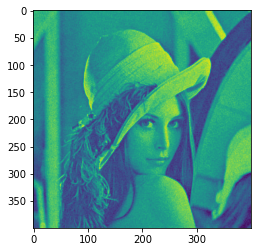

In [4]:
import  matplotlib
image_test = matplotlib.image.imread('D:\\escuela\\WPy64-31040\\hope.jpg')
plt.imshow(image_test)


[[174 168 166 ... 177 173 150]
 [177 170 165 ... 182 163 125]
 [183 175 169 ... 183 167 129]
 ...
 [ 62  62  61 ...  64  67  63]
 [ 49  59  66 ...  71  77  68]
 [ 50  52  66 ...  75  83  68]]
(200, 200)
uint8


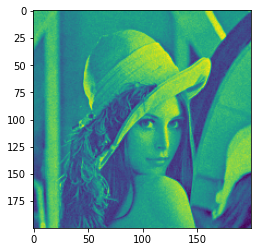

In [5]:
import cv2
img=cv2.imread("D:\\escuela\\WPy64-31040\\hope.jpg", cv2.IMREAD_GRAYSCALE)
print(img)

dim = (200, 200)
  
# resize image
initial_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
# initial_img = cv2.resize(poisson_noise, dim, interpolation = cv2.INTER_AREA)

#io.imsave("initial_image.jpg", initial_img)
print(initial_img.shape)
print(initial_img.dtype)

plt.imshow(initial_img)

In [6]:
from nangs import PDE
import math

K=50

class PeronaMalik(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        
        # compute first-order derivatives
        grads = self.computeGrads(outputs, inputs)
        dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        
        # compute second-order derivatives
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0]        
        dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        #dudas
        dp2dpxdpy=self.computeGrads(dpdx, inputs)[:, 1]
        dp2dpydpx=self.computeGrads(dpdy, inputs)[:, 0]
        
        
        # compute loss
        #dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        return {'pde': dpdx*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dx2)+(dpdy*dp2dpydpx))
                      -dpdy*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dpxdpy)+(dpdy*dp2dy2))
               +torch.exp(  -(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2) * ( dp2dx2+dp2dy2 )-dpdt}
    
pde = PeronaMalik(inputs=('x', 'y', 't'), outputs='p')

In [7]:
import torch
import random


class BaseSampler():
    def __init__(self, data, n_samples=1, device="cpu"):
        assert isinstance(data, dict), "you must pass a dict with your data"
        self.device = device
        self.data = data
        self.vars = tuple(data.keys())
        self.n_samples = n_samples

    def _sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        sample = self.sample(n_samples)
        return torch.stack([
            sample[var]
            for var in self.vars
        ], axis=-1)

    def sample(self, n_samples=None):
        raise ValueError("you must implement this method")
    
    



class Perona_Sampler(BaseSampler):
    def __init__(self, data, n_samples=1, device="cpu"):
        super().__init__(data, n_samples, device)
        for var, lims in data.items():
            if isinstance(lims, list):
                assert len(
                    lims) == 2, "you must pass a list with the min and max limits"
            elif isinstance(lims, int) or isinstance(lims, float):
                data[var] = [lims, lims]
            else:
                raise ValueError("invalid limits")

    def sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        a={
            
            var: torch.rand(n_samples, device=self.device) *
            (lims[1] - lims[0]) + lims[0]
            for var, lims in self.data.items()
        }
        i=0
        b_list=[]
        for item in range(n_samples):
            b=random.uniform(0,200)
            if i<-1:
                b_list.append(0)
            else:
                b_list.append(b)
            i+=1
            #print(i,b)
            
        
        b_tensor=torch.tensor(b_list,device=self.device)
        #for i in b_tensor:
        #    b_tensor[i]=b
        result={'x':a['x'],'y':a['y'],'t':b_tensor}  
        
        if random.randint(0,100)<=1:
            print(result)
        return result
    
    
class Perona_Sampler_Ini(BaseSampler):
    def __init__(self, data, n_samples=1, device="cpu"):
        super().__init__(data, n_samples, device)
        for var, lims in data.items():
            if isinstance(lims, list):
                assert len(
                    lims) == 2, "you must pass a list with the min and max limits"
            elif isinstance(lims, int) or isinstance(lims, float):
                data[var] = [lims, lims]
            else:
                raise ValueError("invalid limits")

    def sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        a={
            
            var: torch.rand(n_samples, device=self.device) *
            (lims[1] - lims[0]) + lims[0]
            for var, lims in self.data.items()
        }
        i=0
        b_list=[]
        for item in range(n_samples):
            b=random.uniform(0,200)
            if i<n_samples/5:
                b_list.append(0)
            else:
                b_list.append(b)
            i+=1
            #print(i,b)
            
        
        b_tensor=torch.tensor(b_list,device=self.device)
        #for i in b_tensor:
        #    b_tensor[i]=b
        result={'x':a['x'],'y':a['y'],'t':b_tensor}  
        #print(result)
        return result


In [8]:
n_samples = 160000
print("a")

a


In [9]:
# define the sampler

from nangs import RandomSampler

sampler = Perona_Sampler({
    'x': [0., 200.], 
    'y': [0., 200.],
    't': [0., 200.], 
}, device=device, n_samples=1000)

pde.set_sampler(sampler)
print("a")

a


In [10]:
## define the sampler

#from nangs import RandomSampler
##import random

#sampler = RandomSampler({
#    'x': [0., 1.], 
#    'y': [0., 1.],
#    't': [0., 1.], 
#}, device=device, n_samples=1000)

#pde.set_sampler(sampler)
#print("a")

In [11]:


def initial_condition_Adr(x,y):
    res = torch.zeros(len(x))
    for i in range(len(x)):
        if len(x) == 1:
            res[i] = initial_img[int(x.item()),int(y.item())]
        else:
            res[i]=(initial_img [int(x[i]),int(y[i])])
        #print(res)
    #print("hey")
    #print(res)        
    return res

In [12]:


#def initial_condition_Adr(x,y):
#    res = torch.zeros(len(x))
#    for i in range(len(x)):
#        if len(x) == 1:
#            res[i] = initial_img[50*int(x.item()),50*int(y.item())]
#        else:
#            res[i]=(initial_img [50*int(x[i]),50*int(y[i])])
#        #print(res)
#    #print("hey")
#    #print(res)        
#    return res

In [13]:
def cero_f(x,y):
    res = torch.zeros(len(x))
    for i in range(0,len(x)):
        res[i]=0
    return res

In [14]:
def cero_f(n_samples):
    return torch.zeros(n_samples)

In [15]:
def f_circle(x,y):
    z = (x - 100)**2 + (y - 100)**2
    for i in range(0,len(z)):
        if z[i] <= 800:
            z[i] = 30
        else: z[i] = 200

    return z

In [16]:
def cart_prod(*args):
    grids =np.meshgrid(*args,indexing='ij')
    return np.stack(grids,axis=-1).reshape(-1,len(args))

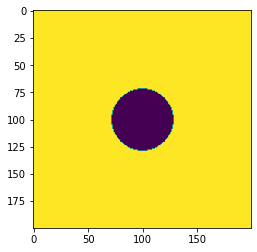

In [17]:
x = np.linspace(0,199,200)

grid=cart_prod(x,x)


xs, ys= grid[:, 0:1], grid[:,1:2]
ini_circle=f_circle(xs,ys).reshape(200,200)

plt.imshow(ini_circle)


In [18]:
#def rotate_90_rigth(image):
#    dim_x=len(image[0])
#    dime_y=len(image)
#    result=np.zeros((dim_x,dime_y))
#   for i in range(len(image)):
#        for j in range(len(image[0])):
#            result[i][j]=
    

In [19]:
#from nangs import Dirichlet

#temp=cero_f(n_samples)

#left = Dirichlet(
#    RandomSampler({'x': 0., 'y': [0., 200.],'t': [0., 200.] }, device=device, n_samples=n_samples), 
#    lambda inputs: {'p' : temp},
    
#    name="left"
#)
#print(cero_f(n_samples))

#pde.add_boco(left)
#print("a")

In [20]:
#from nangs import Dirichlet


#right = Dirichlet(
#    RandomSampler({'x': 200., 'y': [0., 200.],'t': [0., 200.]}, device=device, n_samples=n_samples), 
#    lambda inputs: {'p' :  cero_f(x,y)},
 
#    name="right"
#)

#pde.add_boco(right)
#print("a") 

In [21]:
#from nangs import Dirichlet


#up = Dirichlet(
#    RandomSampler({'x': [0.,200.], 'y': 0,'t': [0., 200.]}, device=device, n_samples=n_samples), 
#    lambda inputs: {'p' : cero_f(n_samples)},
#    name="up"
#)

#pde.add_boco(up)
#print("a")

In [22]:
#from nangs import Dirichlet


#down = Dirichlet(
#    RandomSampler({'x': [0.,200.], 'y': 0,'t': [0., 200.]}, device=device, n_samples=n_samples), 
#    lambda inputs: {'p' : cero_f(n_samples)},
#    name="down"
#)

#pde.add_boco(down)
#print("a")

In [23]:
from nangs import Dirichlet



foto = Dirichlet(
    Perona_Sampler_Ini({'x': [0., 200.], 'y': [0., 200.],'t':0}, device=device, n_samples=n_samples), 
     lambda inputs: {'p' :f_circle(inputs['x'],inputs['y'])},
    name="foto"
)
#print(temp)
                           
pde.add_boco(foto)
print("a")

a


In [24]:
import torch


class Sine(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


def block(i, o):
    fc = torch.nn.Linear(i, o)
    return torch.nn.Sequential(
        Sine(),
        torch.nn.Linear(i, o)
    )


class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        
        fc_in = torch.nn.Linear(inputs, neurons)
        fc_hidden = [
            block(neurons, neurons)
            for layer in range(layers-1)
        ]
        fc_out = block(neurons, outputs)

        self.mlp = torch.nn.Sequential(
            fc_in,
            *fc_hidden,
            fc_out
        )

    def forward(self, x):
        return self.mlp(x)
    
    #def anzatc(self, u, xs):
    #    """ Anzatc-transformation of the model-output needed for binding initial and boundary conditions. """
    #    # Get tensor of spatial variables and time-tensor.
    #    xs_spatial = xs[:, :self.ndims_spatial]
    #    t = xs[:, self.ndims - 1:self.ndims]
    #    lower, upper = [lims[0] for lims in self.domain], [lims[1] for lims in self.domain]
    #    lower_spatial, upper_spatial = [torch.Tensor(lst[:self.ndims_spatial]).reshape(1, -1).float()
    #                                    for lst in (lower, upper)]
    #    t0 = lower[-1]

        # Apply transformation to bind the boundary condition.
    #    if self.boundary_condition is not None:
    #        u = (u * (torch.prod((xs_spatial - lower_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True) *
    #                  torch.prod((upper_spatial - xs_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True))
    #                 + self.boundary_condition)

        # Apply transformation to bind the initial condition.
    #    if self.initial_condition is not None:
    #        _xs_spatial = [xs_spatial[:, i] for i in range(xs_spatial.shape[1])]
    #        u = ((nn.Sigmoid()((t - t0) / torch.exp(self.log_scale)) - .5) * u
    #             + self.initial_condition(*_xs_spatial).view(-1, 1))
    #    return u

In [25]:
#n_samples = 100000

In [26]:
# solve

#from nangs import MLP

#funciona cpn 800 lo cambiea 600
LR = 1e-2
N_STEPS = 600
NUM_LAYERS = 3
NUM_HIDDEN = 128
print(len(pde.inputs))
print(len(pde.outputs))

for item in pde.inputs:
    print(item)
for item in pde.outputs:
    print(item)
    
    
mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

3
1
x
y
t
p


  2%|█▌                                                                             | 12/600 [01:31<1:15:28,  7.70s/it]

{'x': tensor([ 17.8382, 118.9460,  17.2963,  98.0027, 104.5360,  99.5361, 196.6224,
        135.7647,   9.2328, 121.3115, 100.3210,  19.3026,  83.9047, 194.9356,
         70.2438, 170.9602, 161.6561, 187.3965, 173.5180,  73.8560, 187.4314,
         84.9999,  99.6411,   4.8564,  60.3289, 187.1319, 104.1570, 108.1378,
        178.1285,  76.6136,  31.7858, 197.4240,  26.6237, 125.9568, 143.4110,
          4.4146, 165.1775, 137.2388, 162.2825, 105.3698,  85.0211, 145.9569,
         68.1137, 149.9368,  39.8301, 139.9293,  72.0841,  84.8215,  41.5990,
        186.2993,  18.2891,  32.1869,  71.8865,  43.7403, 127.0661,  16.2521,
         90.4072,  96.7038,  26.7604,  23.1922,   9.6276,  52.2547, 167.6686,
         72.7195, 125.8998, 152.7257, 134.3138, 128.3525, 104.1935,  89.1637,
         34.3943, 155.5223,  68.2318, 150.2133, 147.7115,  82.5425, 107.7283,
         87.6943,  33.9045,  68.2649, 111.2354, 134.3331, 145.8958, 167.6492,
         41.5190, 170.3302, 191.2254, 123.3563,  87.0250, 

{'pde': 0.00012, 'foto': 8757.65234}:  17%|███████▎                                  | 104/600 [12:21<55:23,  6.70s/it]

{'x': tensor([3.4567e+01, 8.2368e+01, 7.8264e+01, 9.3404e+01, 7.0436e+01, 8.5972e+01,
        8.6741e+01, 5.4401e-01, 1.1433e+00, 5.7939e+01, 8.1206e+01, 1.5472e+02,
        1.2886e+02, 5.8074e+01, 6.1016e+01, 1.4162e+02, 4.1700e+00, 1.0278e+02,
        4.9789e+01, 1.3851e+02, 9.2775e+01, 5.2628e+01, 3.4286e+01, 5.5592e+01,
        6.1557e+01, 7.9956e+01, 5.0724e+01, 1.4821e+02, 1.1740e+02, 2.1070e+01,
        1.2188e+02, 1.4750e+02, 2.1354e+01, 7.0672e+01, 1.5850e+02, 9.8056e+01,
        6.7152e+01, 6.9294e+01, 3.2714e+01, 7.5255e+01, 9.6529e+01, 1.8852e+01,
        7.0581e+00, 1.6662e+02, 1.8432e+02, 1.2893e+02, 1.7862e+02, 1.0197e+02,
        1.7887e+02, 1.2159e+02, 4.7658e+01, 1.3708e+01, 1.6550e+02, 2.1671e+01,
        8.7673e+01, 1.7295e+02, 1.0631e+02, 1.2993e+01, 1.5136e+01, 1.1643e+02,
        7.0808e-01, 1.8257e+02, 2.9219e+01, 1.7148e+02, 9.2345e+01, 1.2541e+02,
        2.0026e+01, 1.4721e+02, 1.4313e+02, 1.6795e+02, 1.7108e+02, 2.5524e+01,
        1.4401e+02, 2.9652e+01, 5.

{'pde': 0.00012, 'foto': 8757.65234}:  30%|████████████▌                             | 180/600 [20:20<36:13,  5.18s/it]

{'x': tensor([1.7055e+02, 2.0531e+01, 1.6255e+02, 4.9113e+00, 1.7615e+02, 1.6974e+02,
        4.4137e+01, 1.4328e+01, 1.5575e+02, 1.8610e+02, 3.8868e+01, 1.5028e+02,
        1.5687e+02, 1.4863e+02, 1.3032e+02, 8.5390e+01, 9.3604e+01, 1.7245e+02,
        4.9035e+01, 1.4543e+02, 1.7336e+02, 1.7066e+02, 1.2411e+02, 1.6882e+02,
        1.8695e+02, 3.1676e+01, 1.9843e+01, 7.1787e+01, 1.0699e+02, 1.9709e+01,
        1.9195e+02, 1.8999e+02, 1.3003e+02, 1.6794e+02, 3.9381e+00, 1.4755e+02,
        8.6491e+01, 1.7341e+02, 1.6402e+02, 6.3443e+00, 5.1831e+01, 1.0730e+02,
        7.8078e+01, 8.0154e+01, 1.5715e+02, 1.7068e+02, 1.7774e+02, 6.9275e+01,
        1.7534e+02, 1.3737e+02, 1.2099e+02, 1.0353e+02, 7.8307e+01, 7.4679e+01,
        9.4181e+01, 8.3912e+01, 2.7937e+01, 1.8080e+02, 1.2044e+02, 4.2996e+00,
        5.5338e+01, 1.3239e+02, 8.6795e+01, 1.8606e+02, 4.5391e+01, 1.3204e+02,
        1.5839e+02, 1.5569e+01, 3.2167e+01, 1.0599e+02, 8.2668e+01, 7.3434e+01,
        4.4020e+01, 1.9464e+01, 1.

{'pde': 0.00012, 'foto': 8757.65234}:  33%|█████████████▊                            | 198/600 [21:54<34:36,  5.16s/it]

{'x': tensor([1.8386e+01, 9.7387e+01, 1.1803e+02, 1.3995e+02, 1.3476e+02, 1.7263e+02,
        1.5663e+02, 7.4961e+01, 3.2945e+01, 7.6974e+00, 4.5455e+01, 1.7038e+02,
        1.8868e+02, 1.1078e+02, 1.0965e+02, 1.7981e+02, 9.0252e+01, 7.7881e+01,
        3.6373e+00, 4.5881e+01, 1.8479e+02, 1.9835e+02, 6.0184e+01, 1.6707e+02,
        5.4561e+00, 9.8954e+01, 1.9644e+02, 4.0568e+01, 1.6377e+02, 1.6752e+02,
        2.8327e+01, 8.5961e+01, 1.6361e+01, 1.7883e+02, 8.6165e+01, 1.1136e+02,
        5.3519e+01, 2.2588e+01, 1.9920e+02, 1.1806e+02, 7.0146e+01, 1.1223e+02,
        2.9379e+00, 1.4382e+02, 1.0014e+02, 1.5053e+02, 1.1095e+02, 1.7752e+01,
        6.7744e+01, 1.5735e+02, 1.4493e+02, 1.9682e+02, 1.1846e+02, 1.7450e+02,
        1.3818e+02, 1.9837e+02, 9.6097e+01, 1.2650e+02, 1.9158e+02, 1.9372e+02,
        9.9170e+01, 3.9064e+01, 1.7050e+02, 2.9654e+00, 8.7649e+01, 1.6506e+02,
        1.7808e+02, 4.5784e+01, 1.4609e+02, 1.8033e+01, 1.7235e+02, 8.8628e+01,
        1.9728e+02, 1.0464e+01, 1.

{'pde': 1.56681, 'foto': 1708.52563}:  52%|█████████████████████▋                    | 309/600 [32:02<25:46,  5.31s/it]

{'x': tensor([ 55.8157, 136.5387,  52.0595, 121.7772,  33.6120,  34.1031,  33.6392,
        161.4900, 139.9617,  33.8634, 197.0497, 151.0315, 161.8583,  98.6173,
         90.8901, 178.5596, 101.9103, 136.2469, 150.5872,  68.8347,  86.0804,
        148.0613,  20.9152,  69.2644,  86.6875, 126.2820, 125.1487,  31.7135,
        131.4579, 109.0274,  90.8124, 119.8716,  61.3536,  22.7564,  59.9857,
         46.0774,  15.7198, 140.0726, 182.7218,  74.7752, 186.6078, 129.0010,
         82.0305,  71.6420,  38.1821,  40.8191,  72.9116, 179.8237, 186.5087,
        157.5411, 192.5777, 131.4900,  28.1856,  47.0037,  99.6191, 198.2228,
        148.7177, 129.4268, 185.3927,  29.0940,  97.6306, 181.8624,  12.0120,
         49.8481,  67.3580, 179.9326,  14.0100,  36.4413, 164.7867, 184.7025,
        156.3687,  68.0887,   3.4767,   6.1487, 112.2720, 178.9236,  12.3104,
        189.9753, 156.7957,  49.4066,  59.7135, 197.1160,   5.7460,  55.4310,
        153.4732,   5.3429, 192.9596,  59.8815, 191.3187, 

{'pde': 1.56681, 'foto': 1708.52563}:  56%|███████████████████████▌                  | 337/600 [34:28<23:03,  5.26s/it]

{'x': tensor([3.7192e+01, 1.4450e+02, 1.6760e+02, 1.6316e+02, 1.7592e+02, 1.3106e+02,
        2.6219e+01, 1.0479e+02, 7.9441e+01, 7.3479e+01, 5.3462e+01, 1.2616e+02,
        8.6469e+01, 1.0407e+02, 4.1137e+01, 1.0667e+02, 1.7824e+02, 1.7326e+02,
        3.8269e+01, 7.7189e+01, 1.3083e+01, 4.7711e+01, 7.8645e+01, 6.1419e+00,
        5.5654e+01, 1.0315e+02, 1.8823e+02, 5.1169e+01, 1.6863e+02, 8.1232e+01,
        2.5741e+01, 5.0688e+01, 1.7182e+02, 1.6507e+02, 1.5776e+02, 1.5749e+02,
        1.0413e+02, 3.2062e+01, 1.5526e+02, 4.7597e+01, 4.7487e+01, 1.7011e+02,
        1.8940e+02, 7.3499e+01, 1.2826e+02, 3.0920e+01, 3.7472e+01, 1.7937e+02,
        5.8025e+01, 1.4685e+02, 1.4311e+02, 1.2676e+02, 1.9996e+02, 1.2153e+02,
        1.9040e+02, 2.6936e+01, 1.8819e+02, 8.8769e+01, 3.4770e+01, 1.8275e+01,
        7.3249e+01, 6.0154e+01, 1.9286e+02, 1.3622e+02, 1.7771e+02, 1.1799e+02,
        7.8397e+01, 4.2444e+01, 9.8619e+01, 1.6221e+02, 1.6960e+02, 1.8772e+02,
        1.1835e+02, 1.2171e+02, 3.

{'pde': 1.56681, 'foto': 1708.52563}:  64%|██████████████████████████▋               | 382/600 [38:28<18:48,  5.17s/it]

{'x': tensor([1.1828e+02, 1.3085e+01, 1.4132e+02, 1.1151e+02, 1.0174e+02, 7.6846e+00,
        4.1029e+01, 1.2470e+02, 1.0283e+02, 7.5439e+01, 2.3280e+01, 1.3153e+02,
        1.6927e+02, 3.7080e+01, 1.2694e+02, 1.0372e+02, 1.5377e+02, 1.2303e+02,
        1.0796e+01, 1.6033e+02, 1.0411e+02, 1.0632e+02, 1.9809e+02, 1.5758e+02,
        1.8774e+02, 1.0856e+01, 8.7066e+01, 7.2398e+01, 1.5190e+00, 1.1976e+02,
        6.3507e+01, 1.6461e+02, 5.5755e+01, 1.7455e+02, 1.4108e+02, 7.1287e+01,
        1.1822e+02, 1.7109e+02, 5.1092e+01, 1.5366e+02, 1.0129e+02, 9.4793e+01,
        2.3808e+01, 1.2848e+02, 8.4996e+01, 1.2180e+02, 1.2933e+02, 1.9767e+01,
        2.7030e+01, 7.2151e+01, 8.1542e+00, 4.8482e+01, 1.1779e+02, 1.8321e+01,
        1.4232e+02, 1.2436e+02, 6.4390e+01, 8.8872e+01, 1.2691e+02, 8.8587e+01,
        1.0687e+02, 8.9722e+01, 3.3171e+01, 1.6008e+02, 1.7986e+02, 7.9442e+01,
        3.6188e+01, 5.8872e+01, 9.3989e+01, 1.4042e+02, 5.0468e+01, 1.2371e+02,
        1.2943e+02, 1.4683e+02, 1.

{'pde': 11.24925, 'foto': 1477.35901}:  82%|█████████████████████████████████▍       | 489/600 [48:04<09:30,  5.14s/it]

{'x': tensor([1.1018e+02, 1.4629e+02, 1.0173e+02, 3.0162e+01, 1.8505e+02, 5.6629e+01,
        1.0860e+02, 8.5018e+01, 1.9451e+02, 2.7346e+01, 6.7166e+01, 1.2137e+02,
        1.6285e+02, 1.7424e+02, 1.0227e+02, 6.3107e+01, 1.8845e+02, 1.0821e+02,
        1.8651e+02, 1.1006e+02, 5.4294e+01, 8.6807e+01, 4.8637e+01, 1.3361e+02,
        1.3804e+02, 5.5185e+01, 5.8198e+01, 1.2029e+02, 1.2815e+01, 1.5735e+02,
        1.3341e+02, 1.7353e+02, 2.3990e+01, 1.4844e+02, 7.4421e+01, 8.5406e+01,
        9.8138e+01, 7.7497e+01, 4.6617e+01, 5.2301e+01, 6.0578e+01, 1.1997e+02,
        5.2906e+01, 1.5812e+02, 8.7156e+01, 8.1763e+00, 1.5986e+02, 1.1973e+02,
        1.6669e+02, 1.6372e+02, 6.5183e+01, 6.1062e+00, 1.0169e+02, 1.2029e+02,
        1.2339e+02, 1.3728e+02, 1.3438e+02, 7.0985e+01, 1.0141e+02, 1.7673e+02,
        1.1859e+02, 1.5555e+01, 6.3437e+01, 1.5652e+02, 4.3285e+00, 1.8811e+02,
        7.3619e+01, 1.1502e+02, 1.3738e+02, 7.6168e+01, 1.7244e+02, 6.8751e+01,
        1.7908e+02, 1.9424e+01, 1.

{'pde': 33.86814, 'foto': 1317.37878}:  85%|██████████████████████████████████▊      | 509/600 [49:48<07:51,  5.19s/it]

{'x': tensor([3.4849e+01, 6.3412e+01, 1.1340e+02, 1.5545e+02, 1.7422e+01, 2.2386e+01,
        1.9235e+02, 1.2486e+02, 1.6591e+02, 7.8683e+01, 8.9468e+01, 7.7317e+01,
        1.7399e+01, 1.7110e+02, 1.4451e+02, 1.9201e+02, 1.0210e+02, 4.2026e+01,
        7.5076e+01, 3.7563e+01, 1.8220e+02, 1.8727e+02, 1.8779e+02, 1.7987e+02,
        6.2386e+01, 1.9176e+02, 1.7182e+02, 6.7465e+01, 1.6495e+02, 6.2355e+01,
        1.9821e+02, 1.2706e+00, 3.9194e+01, 5.9489e+01, 2.9454e+01, 1.2214e+02,
        4.8677e+01, 9.0932e+01, 1.1626e+02, 1.6925e+02, 9.4864e+00, 1.8853e+02,
        1.8889e+02, 4.5738e+01, 4.5495e+01, 1.7907e+02, 1.3236e+02, 1.9937e+02,
        7.8108e+01, 1.9480e+02, 1.5638e+01, 1.0981e+02, 8.9343e+01, 1.0012e+02,
        1.0026e+02, 1.2096e+02, 1.0711e+02, 1.2392e+02, 1.0405e+02, 1.3839e+02,
        2.5797e+01, 9.2178e+01, 9.1382e+01, 1.4103e+02, 1.6846e+02, 1.6467e+02,
        3.8976e+01, 1.1090e+02, 1.9905e+02, 1.4121e+02, 2.1484e+00, 3.7225e+01,
        1.8572e+02, 1.4044e+02, 5.

{'pde': 33.86814, 'foto': 1317.37878}:  88%|████████████████████████████████████▏    | 530/600 [51:36<05:59,  5.13s/it]

{'x': tensor([8.9531e+01, 1.1857e+02, 1.3575e+02, 1.9398e+01, 2.0228e+01, 3.6290e+00,
        2.7633e+01, 3.1188e+01, 1.2738e+02, 1.9590e+02, 1.3188e+02, 4.4604e+00,
        1.4075e+02, 4.7244e+01, 1.2335e+02, 1.4612e+02, 1.9588e+02, 1.1777e+02,
        1.9557e+02, 1.7477e+02, 9.5380e+01, 1.2280e+02, 1.4442e+02, 1.0885e+02,
        2.9023e+00, 8.5353e+01, 1.8484e+01, 8.0531e+00, 1.5479e+02, 1.0837e+02,
        1.3394e+02, 1.0300e+02, 1.6497e+02, 1.5030e+02, 1.0975e+02, 5.3922e+01,
        2.0456e+01, 7.8439e+01, 1.8354e+02, 1.5056e+02, 1.1931e+02, 8.7645e+01,
        7.1132e+01, 1.2235e+02, 6.0629e+01, 3.0799e+01, 5.8618e+01, 1.6406e+02,
        5.8292e+01, 8.9123e+01, 1.7555e+02, 1.0160e+02, 1.0053e+02, 1.3093e+02,
        1.1053e+02, 5.7595e+01, 1.1420e+02, 1.9264e+02, 1.3930e+02, 1.1406e+02,
        1.2665e+02, 7.4427e+01, 9.1705e+01, 1.4597e+02, 9.4534e+01, 1.3183e+02,
        3.1140e+01, 7.3737e+01, 1.5008e+01, 1.7734e+02, 8.8499e+01, 7.2597e+01,
        1.2930e+02, 1.6199e+02, 8.

{'pde': 33.86814, 'foto': 1317.37878}:  96%|███████████████████████████████████████▏ | 573/600 [55:22<02:32,  5.64s/it]

{'x': tensor([195.0658, 131.7475,  48.2638, 191.8221, 173.2614, 104.5246,  42.4592,
        184.4494,  47.6321, 163.3186, 190.8959,  23.3688,  18.0267,  65.5176,
         53.0516,  58.4275,  29.0818, 121.7813,  72.3772, 178.4885,  27.2747,
         34.4297, 168.3337, 166.6006, 148.1775, 131.5623, 179.2982,  27.6852,
         86.1015, 136.9146,  73.1140, 192.1486,  93.7130,   2.5358,  97.0618,
        191.9565, 160.2711, 136.5429, 161.8944,  70.2701, 163.2517, 105.0725,
        178.4375,  75.3890,  82.2867, 106.6167,  68.0919, 194.3286, 178.3216,
        197.7631, 182.1361,  20.1351,  43.6090,  67.3066,  20.2734,  69.2358,
         41.2903, 112.6819, 106.6272, 161.3684,  61.6339, 179.1026, 142.0676,
         83.7964, 171.2532,  93.6519,  76.2562, 169.3331, 168.1846, 197.8690,
          8.2271, 194.2518,  16.0312, 153.3580, 193.2928, 131.0928,  57.4583,
        191.9442, 106.8489,   1.1372,  59.3589,  68.8455, 199.4872,  85.4943,
        119.1944,   5.4186,  35.2847,  71.2669, 145.7211, 

{'pde': 33.86814, 'foto': 1317.37878}: 100%|████████████████████████████████████████▉| 599/600 [57:42<00:05,  5.23s/it]

{'x': tensor([ 79.2667, 174.9250, 119.4986,  56.0752, 197.1105, 160.8731,  32.3973,
        180.5279, 115.0567, 138.6458,  90.2314,  92.1946, 105.6020, 125.1654,
        127.4024, 173.4877, 172.9066,  36.4557,  63.9275, 190.5565, 195.8034,
        107.0721,  89.5105, 139.9251, 155.4685, 135.3155,  43.7633, 190.7036,
         52.7232, 139.6797,  20.9219, 175.8678, 136.7172,  71.5199,  67.7164,
         29.7171,  39.0595, 103.6364, 140.5717, 148.7163,  43.5020, 135.4945,
         35.4629,  31.3086, 107.0815, 196.9336, 138.3181, 124.4374,  48.3392,
         41.7330,   2.3769, 138.7603, 114.7006, 107.9718,  93.7861, 192.8369,
         49.1966, 115.3545, 148.3382,  71.7276,   4.1196,  75.3577, 134.1224,
        173.2806, 154.8612, 158.6056, 160.3132,   8.8779, 105.7111, 156.2402,
        195.3563,  10.0128,  92.7000,  29.1546,  60.9219, 108.1046,  88.4115,
        166.2356,  13.8848, 189.1380,  10.8602, 182.0095,  67.3321, 147.7296,
         54.7356, 142.9292,  90.6618, 113.0528, 161.4287, 

{'pde': 46.27917, 'foto': 1227.42139}: 100%|█████████████████████████████████████████| 600/600 [57:47<00:00,  5.78s/it]

Wall time: 57min 47s


<AxesSubplot:>

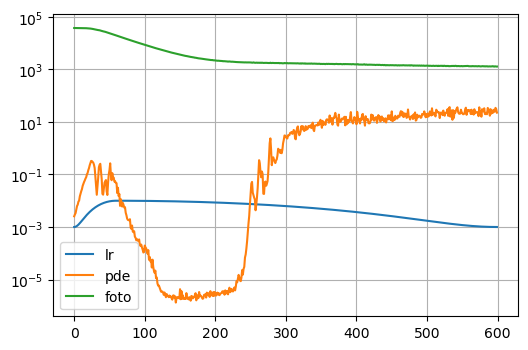

In [27]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

(200, 200)
float64


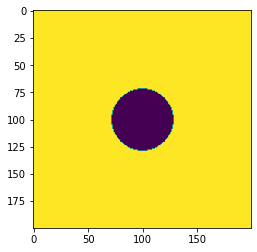

In [28]:
print(ini_circle.shape)
print(ini_circle.dtype)
plt.imshow(ini_circle)


In [29]:
x = np.linspace(0,199,200)
y = np.linspace(0,199,200)
t=0

grid=cart_prod(x,y,t)
xs, ys= grid[:, 0:1], grid[:,1:2]

X = torch.from_numpy(grid).float().to(device)
image_final =  pde.eval(X)

xs, ys= grid[:, 0:1], grid[:,1:2]
print(image_final.shape)
print(image_final.dtype)

#plt.imshow(f_circle(xs,ys).reshape(200,200))

torch.Size([40000, 1])
torch.float32


In [30]:
#x = np.linspace(0,199,200)
#y = np.linspace(0,199,200)
#t =1

##Full=np.meshgrid(x, y)a

#_x, _y = np.meshgrid(x, y)
#grid = np.stack(np.meshgrid(x, y, t), -1).reshape(-1, 3)
#X = torch.from_numpy(grid).float().to(device)

#image_final =  pde.eval(X)
##print(image_test)
#print(image_final.shape)
#print(image_final.dtype)

##rrrrrplt.imshow(image_final)

In [31]:
imashow=image_final.reshape(200,200)

In [32]:
def float_to_int(imashow):
    for i in range(len(imashow)):
        for j in range (len(imashow)):
            imashow[i][j]=int(imashow[i][j])

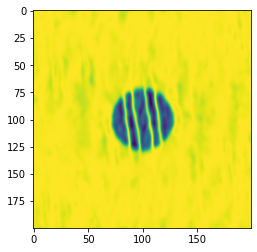

In [33]:
#float_to_int(imashow)
plt.imshow(imashow)

In [34]:
for i in range(len(imashow)):
    pass
len(imashow[0])

200

In [35]:
print(imashow)

tensor([[199.1726, 199.0995, 198.4061,  ..., 198.4673, 198.6196, 198.7944],
        [198.9915, 199.1696, 199.0367,  ..., 198.8531, 198.9989, 199.1138],
        [199.1731, 199.0637, 199.1401,  ..., 199.1179, 199.1820, 199.1924],
        ...,
        [199.1779, 199.1712, 199.1784,  ..., 198.7752, 198.8684, 199.0806],
        [199.1775, 199.1891, 199.1860,  ..., 199.1808, 199.1726, 199.1815],
        [199.1120, 199.1277, 199.0338,  ..., 199.0467, 198.9960, 199.0167]])


In [36]:
def matrix_substract(a,b):
    res=np.zeros_like(a)
    for i in range(len(a)):
        for j in range(len(a[0])):
            res[i][j]=abs(abs(a[i][j])-abs(b[i][j]))
            
    return res

In [37]:
sub=matrix_substract(ini_circle,imashow)
sum=0
for i in range(len(sub)):
        for j in range(len(sub[0])):
            sum+=sub[i][j]
print(   sum/  (  len(sub)*len(sub[0])  )   )

1.7516295841693879


In [38]:
7.758575,7.69635


(7.758575, 7.69635)

In [39]:
n_samples = 111111111/600
LR = 1e-2
N_STEPS = 1000
NUM_LAYERS = 4
NUM_HIDDEN = 64